In [16]:
import requests
import csv
import os
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
from citipy import citipy
from api_keys import weather_api_key
from pprint import pprint
from scipy.stats import linregress
import matplotlib.patches as mpl_patches

In [84]:
lat = []
lng = []
nearest_city =[]
nearest_ctry =[]
temp_day = []
temp_night = []
temp_max = []
humidity = []
wind = []
clouds = []
time = []
data_dict = []
city_dict = []

num_cities = 0
counter = 10
hemisphere = [0 for x in range(counter)]

csvpath = os.path.join('.', 'data', 'cities_data.csv')
output = open(csvpath, 'w', newline ='')
csvwriter = csv.writer(output, quotechar=' ', quoting=csv.QUOTE_MINIMAL)
csvwriter.writerow(['City_ID','City','Country','Latitude','Longitude','Max_Temp(F)','Humidity(%)','Cloudiness','Wind_Speed(MPH)'])

while num_cities < counter:
    lat_rnd = random.uniform(-90,90)
    lng_rnd = random.uniform(-180,180)
    city = citipy.nearest_city(lat_rnd, lng_rnd)
    city_rnd = city.city_name
    city_rnd = city_rnd.replace("''","")
    ctry_rnd = city.country_code
    ctry_rnd = ctry_rnd.replace("''","")
    
    url ="http://api.openweathermap.org/data/2.5/weather?q=" + city_rnd + "," + ctry_rnd + "&appid=a7a1f8581953b7105f0c5ef795920a44"    

    data = requests.get(url).json()
    
    if data['cod']=='404':
        continue
    else:
        lat_new = data["coord"]['lat']
        lng_new = data['coord']['lon']
        nearest_city.append(city_rnd)
        nearest_ctry.append(ctry_rnd)
        
        url = "http://api.openweathermap.org/data/2.5/onecall?lat=" + str(lat_new) + "&lon=" + str(lng_new) + "&exclude=hourly,current,minutely,alerts&units=imperial&appid=a7a1f8581953b7105f0c5ef795920a44"

        data_latlong = requests.get(url).json()
        lat.append(lat_new)
        lng.append(lng_new)
        data_dict.append(data_latlong)
    
        if lat_new >= 0:
            hemisphere[num_cities] = "Northern"
        else:
            hemisphere[num_cities] = "Southern"

        temp_day.append(data_latlong['daily'][0]['temp']['day'])
        temp_night.append(data_latlong['daily'][0]['temp']['night'])
        temp_max.append(data_latlong['daily'][0]['temp']['max'])
        humidity.append(data_latlong['daily'][0]['humidity'])
        clouds.append(data_latlong['daily'][0]['clouds'])
        wind.append(data_latlong['daily'][0]['wind_speed'])
        time_utc = int(data_latlong['daily'][0]['dt'])
        time.append(datetime.utcfromtimestamp(time_utc).strftime('%Y-%m-%d'))
        
        csvwriter = csv.writer(output, quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow([str(num_cities +1),city_rnd,ctry_rnd,lat_new,lng_new,
                            str(data_latlong['daily'][0]['temp']['max']),
                            str(data_latlong['daily'][0]['humidity']),
                            str(data_latlong['daily'][0]['clouds']),
                            str(data_latlong['daily'][0]['wind_speed'])])

        num_cities += 1

In [85]:

weather_df = pd.DataFrame(
    {'City': nearest_city,
     'Country':nearest_ctry,
     'Longitude': lng,
     'Latitude': lat,
     'Temperature Max (F)': temp_max,
     'Humidity (%)': humidity,
     'Cloudiness': clouds,
     'Wind Speed (mph)': wind,
     'Hemisphere': hemisphere
    })
weather_df

,City,Country,Longitude,Latitude,Temperature Max (F),Humidity (%),Cloudiness,Wind Speed (mph),Hemisphere
0,punta arenas,cl,-70.9167,-53.1500,54.46,50,62,20.33,Southern
1,cape town,za,18.4232,-33.9258,75.31,62,0,11.70,Southern
2,albany,au,117.8917,-35.0169,64.29,74,100,17.25,Southern
3,rikitea,pf,-134.9692,-23.1203,79.18,68,1,10.67,Southern
4,port alfred,za,26.8910,-33.5906,79.77,75,87,14.12,Southern
5,castro,cl,-73.7732,-42.4721,83.77,29,0,6.40,Southern
6,presidencia roque saenz pena,ar,-60.4388,-26.7852,90.88,25,43,7.85,Southern
7,puerto ayora,ec,-90.3518,-0.7393,79.93,75,94,11.14,Southern
8,hirara,jp,125.2833,24.8000,69.80,66,17,7.07,Northern
9,barrow,us,-156.7887,71.2906,-9.40,88,84,5.14,Northern


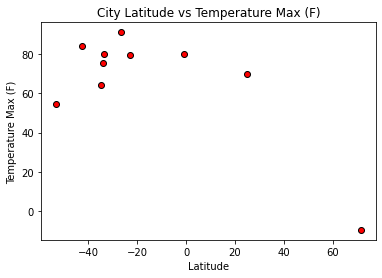

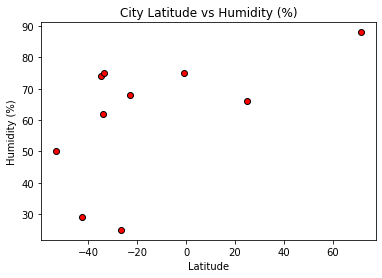

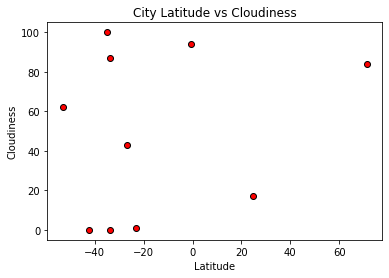

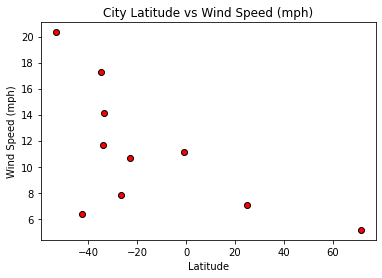

In [86]:
for x in range(4):
    x_values = weather_df['Latitude']
    y_values = weather_df.iloc[:,(x+4)]
    plt.scatter(x_values,y_values, marker='o', facecolors="red", edgecolors = 'black')
    plt.xlabel('Latitude')
    plt.ylabel(weather_df.columns[x+4])
    plt.title('City Latitude vs ' + weather_df.columns[x+4])
    plt.savefig("./figures/" + weather_df.columns[x+4] + "_all_data.png")
    plt.show()
    plt.close()

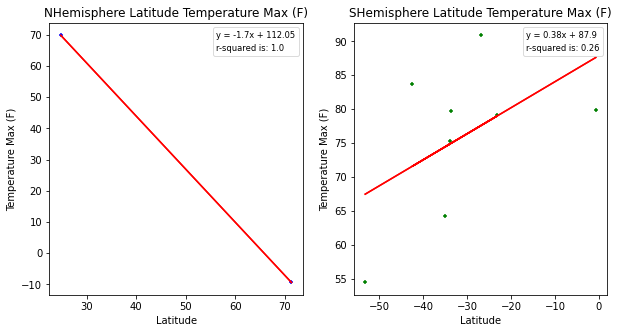

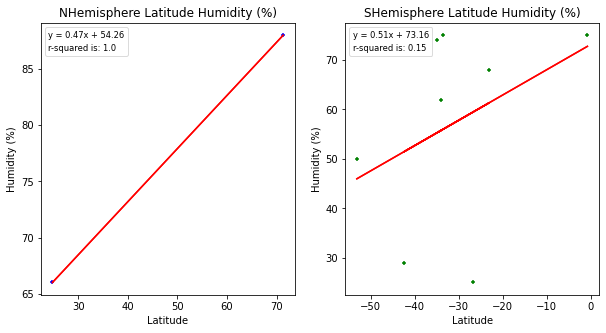

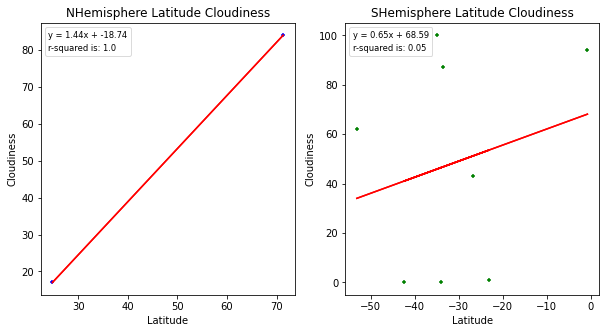

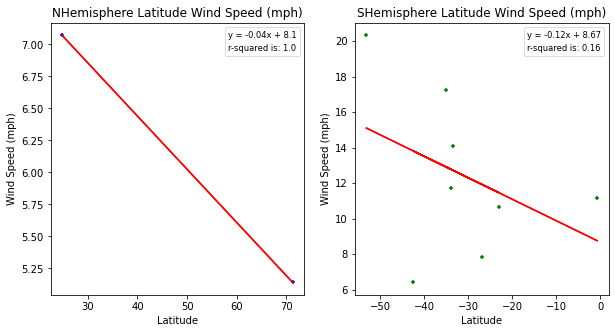

In [87]:

    filtN = weather_df['Hemisphere']=='Northern'
    filtS = weather_df['Hemisphere']=='Southern'
    
    weather_nh_df= weather_df.loc[filtN]
    weather_sh_df= weather_df.loc[filtS]
      
for x in range(4):
    
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        x_values_n = weather_nh_df['Latitude']
        x_values_s = weather_sh_df['Latitude']

        y_values_n = weather_nh_df.iloc[:,(x+4)]
        y_values_s = weather_sh_df.iloc[:,(x+4)]

        ax[0].scatter(x_values_n, y_values_n, s=10, c='b', marker='+')
        ax[0].set_xlabel('Latitude')
        ax[0].set_ylabel(weather_df.columns[x+4])
        ax[0].set_title('NHemisphere Latitude ' + weather_df.columns[x+4])
        
        (slope_n, intercept_n, rvalue_n, pvalue, stderr) = linregress(x_values_n, y_values_n)
        regress_values_n = x_values_n * slope_n + intercept_n
        ax[0].plot(x_values_n,regress_values_n,"r-")
        line_eq_n = "y = " + str(round(slope_n,2)) + "x + " + str(round(intercept_n,2))
        message_n = f'r-squared is: {round(rvalue_n**2,2)}'
        
        labels_n = [line_eq_n, message_n]
        
        ax[0].plot(x_values_n,regress_values_n,"r-")
        handles_n = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2

        ax[0].legend(handles_n, labels_n, loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

        ax[1].scatter(x_values_s,  y_values_s, s=10, c='g', marker='+')
        ax[1].set_xlabel('Latitude')
        ax[1].set_ylabel(weather_df.columns[x+4])
        ax[1].set_title('SHemisphere Latitude ' + weather_df.columns[x+4])   
        
        (slope_s, intercept_s, rvalue_s, pvalue, stderr) = linregress(x_values_s, y_values_s)
        regress_values_s = x_values_s * slope_s + intercept_s
        ax[1].plot(x_values_s,regress_values_s,"r-")
        
        line_eq_s = "y = " + str(round(slope_s,2)) + "x + " + str(round(intercept_s,2))
        message_s = f'r-squared is: {round(rvalue_s**2,2)}'
        
        labels_s = [line_eq_s, message_s]
        
        ax[1].plot(x_values_s,regress_values_s,"r-")
        handles_s = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2

        ax[1].legend(handles_s, labels_s, loc='best', fontsize='small', 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
        
        plt.savefig("./figures/" + weather_df.columns[x+4] + "_byHemisphere.png")
        plt.show()
        plt.close()